In [1]:
import numpy as np
import h5py
import pylab as pl
import arrayfire as af
from scipy.fftpack import fftfreq
from numpy.fft import fft2, ifft2

In [2]:
pl.rcParams['figure.figsize']  = 24, 8.5
pl.rcParams['lines.linewidth'] = 1.5
pl.rcParams['font.family']     = 'serif'
pl.rcParams['font.weight']     = 'bold'
pl.rcParams['font.size']       = 20
pl.rcParams['font.sans-serif'] = 'serif'
pl.rcParams['text.usetex']     = True
pl.rcParams['axes.linewidth']  = 1.5
pl.rcParams['axes.titlesize']  = 'medium'
pl.rcParams['axes.labelsize']  = 'medium'

pl.rcParams['xtick.major.size'] = 8
pl.rcParams['xtick.minor.size'] = 4
pl.rcParams['xtick.major.pad']  = 8
pl.rcParams['xtick.minor.pad']  = 8
pl.rcParams['xtick.color']      = 'k'
pl.rcParams['xtick.labelsize']  = 'medium'
pl.rcParams['xtick.direction']  = 'in'

pl.rcParams['ytick.major.size'] = 8
pl.rcParams['ytick.minor.size'] = 4
pl.rcParams['ytick.major.pad']  = 8
pl.rcParams['ytick.minor.pad']  = 8
pl.rcParams['ytick.color']      = 'k'
pl.rcParams['ytick.labelsize']  = 'medium'
pl.rcParams['ytick.direction']  = 'in'

In [3]:
def fraction_finder(positions_x, positions_y, x_grid, y_grid, dx, dy):
    '''
    function fraction_finder(positions_x, positions_y, x_grid, y_grid, dx, dy)
    -----------------------------------------------------------------------
    Input variables: positions_x and length_domain_x

        positions_x: An one dimensional array of size equal to number of particles taken in the PIC code. 
        It contains the positions of particles in x direction.
        
        positions_y: An one dimensional array of size equal to number of particles taken in the PIC code. 
        It contains the positions of particles in y direction.
        
        x_grid, y_grid: This is an array denoting the position grid chosen in the PIC simulation in
        x and y directions respectively
        

        dx, dy: This is the distance between any two consecutive grid nodes of the position grid 
        in x and y directions respectively

    -----------------------------------------------------------------------    
    returns: x_frac, y_frac
        This function returns the fractions of grid cells needed to perform the 2D charge deposition 

    '''
    x_frac = (positions_x - af.sum(x_grid[0])) / dx
    y_frac = (positions_y - af.sum(y_grid[0])) / dy

    af.eval(x_frac, y_frac)

    return x_frac, y_frac

In [4]:
def periodic_particles(positions_x, positions_y, length_domain_x, length_domain_y):
    '''
    function periodic_particles(positions_x, length_domain_x)
    -----------------------------------------------------------------------
    Input variables: positions_x and length_domain_x

        positions_x, positions_y: One dimensional arrays of size equal to number of particles 
        taken in the PIC code. It contains the positions of particles in x and y directions 
        respectively

        length_domain_x, length_domain_y: This is the length of the domain in x and y directions respectively.
        The domain is assumed to be from x = 0 to x = length_domain_x 

    -----------------------------------------------------------------------    
    returns: positions_x, positions_y
        This function returns the modified positions_x and positions_y such that particle previously 
        gone outside the domain through the left boundary enter via the right boundary and vice versa.
        In other words, the function implements periodic boundary conditions for the particles. 

    '''
    
    # Arrayfire implementation
    # Determine indices of particles which have gone outside the domain
    # through right boundary
    outside_domain_right_x       = af.algorithm.where(positions_x >= length_domain_x)
    outside_domain_top_y         = af.algorithm.where(positions_y >= length_domain_y)
    
    # Determine indices of particles which have gone outside the domain
    # through left boundary         
    outside_domain_left_x        = af.algorithm.where(positions_x <  0  )
    outside_domain_bottom_y      = af.algorithm.where(positions_y <  0  )
    

    if outside_domain_right_x.elements() > 0:
        
        # Apply periodic boundary conditions

        positions_x[outside_domain_right_x] = positions_x[outside_domain_right_x] - length_domain_x

    if outside_domain_top_y.elements() > 0:
        
        # Apply periodic boundary conditions

        positions_y[outside_domain_top_y] = positions_y[outside_domain_top_y] - length_domain_y        

    if outside_domain_left_x.elements() > 0:
        
        # Apply periodic boundary conditions
        
        positions_x[outside_domain_left_x]  = positions_x[outside_domain_left_x] + length_domain_x

    if outside_domain_bottom_y.elements() > 0:
        
        # Apply periodic boundary conditions
        
        positions_y[outside_domain_bottom_y]  = positions_y[outside_domain_bottom_y] + length_domain_y        
        
        
    af.eval(positions_x, positions_y)
    
    return positions_x, positions_y


In [5]:
def periodic_ghost(field, ghost_cells):
    
    '''
    function periodic_ghost(field, ghost_cells)
    -----------------------------------------------------------------------
    Input variables: field, ghost_cells

      field: An 2 dimensinal array representing an input field.(columns--->x, rows---->y)

      ghost_cells: Number of ghost cells taken in the domain

    -----------------------------------------------------------------------
    returns: field
      This function returns the modified field with appropriate values assigned to the ghost nodes to 
      ensure periodicity in the field.
    '''
    
    len_x = field.dims()[1]
    len_y = field.dims()[0]
    
    
    field[ 0 : ghost_cells, :]            = field[len_y -1 - 2 * ghost_cells\
                                                  : len_y -1 - 1 * ghost_cells, :\
                                                 ]
    
    field[ :, 0 : ghost_cells]            = field[:, len_x -1 - 2 * ghost_cells\
                                                  : len_x -1 - 1 * ghost_cells\
                                                 ]
    
    field[len_y - ghost_cells : len_y, :] = field[ghost_cells + 1:\
                                                  2 * ghost_cells + 1, :\
                                                 ]
    
    field[:, len_x - ghost_cells : len_x] = field[: , ghost_cells + 1\
                                                  : 2 * ghost_cells + 1\
                                                 ]
    
    af.eval(field)
    
    return field

## cloud in cell charge deposition: 
\begin{align}
\implies  \rho(\mathbf{x_{i}}, t) &= \frac{1 }{\Delta x}w_{p}q \sum_{p = 1}^{N} b_{1}\left(\frac{x_{p} - \mathbf{x_{i}}}{\Delta x}\right) 
\end{align}

In [6]:
# b1 charge depositor
def charge_b1_depositor(charge_electron,\
                        positions_x, positions_y,\
                        x_grid, y_grid,\
                        ghost_cells,\
                        length_domain_x, length_domain_y\
                       ):
    # b1 charge depositor
    '''
    function charge_b1_depositor(charge_electron,\
                                 positions_x, positions_y,\
                                 x_grid, y_grid,\
                                 ghost_cells,\
                                 length_domain_x, length_domain_x\
                                 )
    -----------------------------------------------------------------------  
    Input variables: charge, zone_x, frac_x, x_grid, dx

        charge_electron: This is a scalar denoting the charge of the macro particle in the PIC code.
        
        positions_x: An one dimensional array of size equal to number of particles taken in the PIC code.
        It contains the positions of particles in x direction.
        
        positions_y:  An one dimensional array of size equal to number of particles taken in the PIC code.
        It contains the positions of particles in y direction.

        x_grid, y_grid: This is an array denoting the position grid chosen in the PIC simulation in
        x and y directions.
        
        ghost_cells: This is the number of ghost cells in the domain
        
        length_domain_x, length_domain_x: This is the length of the domain in x and y.

    -----------------------------------------------------------------------  
    returns: rho
    
        rho: This is an array containing the charges deposited at the density grid nodes.
    '''
    

    number_of_particles = positions_x.elements()

    x_charge_zone = af.data.constant(0, 4 * number_of_particles, dtype=af.Dtype.u32)
    y_charge_zone = af.data.constant(0, 4 * number_of_particles, dtype=af.Dtype.u32)

    # calculating the number of grid cells
    
    nx = ((x_grid.elements()) - 1 - 2 * ghost_cells )  # number of zones
    ny = ((y_grid.elements()) - 1 - 2 * ghost_cells )  # number of zones

    dx = length_domain_x/nx
    dy = length_domain_y/ny

    # Determining the left(x) and bottom (y) indices of the left bottom corner grid node of
    # the grid cell containing the particle
    
    x_zone = (((af.abs(positions_x - af.sum(x_grid[0])))/dx).as_type(af.Dtype.u32))
    y_zone = (((af.abs(positions_y - af.sum(y_grid[0])))/dy).as_type(af.Dtype.u32))

    x_zone_plus = x_zone + 1
    y_zone_plus = y_zone + 1

    # Calculating the fractions needed for calculating the weights
    
    dy_by_delta_y            = (1/dy) * (positions_y-y_grid[y_zone])
    dy_by_delta_y_complement = 1 - dy_by_delta_y

    dx_by_delta_x            = (1/dx) * (positions_x - x_grid[x_zone])
    dx_by_delta_x_complement = 1 - dx_by_delta_x

    # Calculating the weights at all corners
    # Order of corners is available on the main thesis document
    # order -----bottom right --->bottom left---->top left-----> top right
    
    weight_corner1 = dy_by_delta_y_complement * dx_by_delta_x_complement
    weight_corner2 = dy_by_delta_y * dx_by_delta_x_complement
    weight_corner3 = dy_by_delta_y * dx_by_delta_x
    weight_corner4 = dy_by_delta_y_complement * dx_by_delta_x

    charge_by_dxdy = ((charge_electron/(dx*dy)))

    corner1_charge   = weight_corner1 * charge_by_dxdy
    corner2_charge   = weight_corner2 * charge_by_dxdy
    corner3_charge   = weight_corner3 * charge_by_dxdy
    corner4_charge   = weight_corner4 * charge_by_dxdy

    # Concatenating the all the weights for all 4 corners into one vector all_corners_weighted_charge
    
    all_corners_weighted_charge = af.join(0,corner1_charge, corner2_charge, corner3_charge, corner4_charge)

    # concatenating the x indices into x_charge_zone
    
    x_charge_zone[0 * number_of_particles : 1 * number_of_particles] = x_zone
    x_charge_zone[1 * number_of_particles : 2 * number_of_particles] = x_zone
    x_charge_zone[2 * number_of_particles : 3 * number_of_particles] = x_zone_plus
    x_charge_zone[3 * number_of_particles : 4 * number_of_particles] = x_zone_plus

    # concatenating the x indices into x_charge_zone
        
    y_charge_zone[0 * number_of_particles : 1 * number_of_particles] = y_zone
    y_charge_zone[1 * number_of_particles : 2 * number_of_particles] = y_zone_plus
    y_charge_zone[2 * number_of_particles : 3 * number_of_particles] = y_zone_plus
    y_charge_zone[3 * number_of_particles : 4 * number_of_particles] = y_zone

    
    af.eval(x_charge_zone, y_charge_zone)
    af.eval(all_corners_weighted_charge)

    return x_charge_zone, y_charge_zone, all_corners_weighted_charge

In [7]:
def cloud_charge_deposition(charge_electron,\
                            number_of_electrons,\
                            positions_x,\
                            positions_y,\
                            x_grid,\
                            y_grid,\
                            shape_function,\
                            ghost_cells,\
                            length_domain_x,\
                            length_domain_y,\
                            dx,\
                            dy\
                           ):

    '''
    function cloud_charge_deposition(   charge,\
                                        number_of_electrons,\
                                        positions_x,\
                                        positions_y,\
                                        x_grid,\
                                        y_grid,\
                                        shape_function,\
                                        ghost_cells,\
                                        length_domain_x,\
                                        length_domain_y,\
                                        dx,\
                                        dy\
                                   )
    -----------------------------------------------------------------------  
    Input variables: charge, zone_x, frac_x, x_grid, dx

        charge_electron: This is a scalar denoting the charge of the macro particle in the PIC code.
        
        positions_x: An one dimensional array of size equal to number of particles taken in the PIC code.
        It contains the positions of particles in x direction.
        
        positions_y:  An one dimensional array of size equal to number of particles taken in the PIC code.
        It contains the positions of particles in y direction.

        x_grid, y_grid: This is an array denoting the position grid chosen in the PIC simulation in
        x and y directions.
        
        shape_function: The weighting scheme used for the charge deposition.
        
        ghost_cells: This is the number of ghost cells in the domain
        
        length_domain_x, length_domain_y: This is the length of the domain in x and y.

    -----------------------------------------------------------------------  
    returns: rho
    
        rho: This is an array containing the charges deposited at the density grid nodes.    
    '''
    
    elements = x_grid.elements()*y_grid.elements()

    rho_x_indices, \
    rho_y_indices, \
    rho_values_at_these_indices = shape_function(charge_electron,positions_x, positions_y,\
                                                 x_grid, y_grid,\
                                                 ghost_cells, length_domain_x, length_domain_y\
                                                )

    input_indices = (rho_x_indices*(y_grid.elements())+ rho_y_indices)

    rho, temp = np.histogram(input_indices,\
                             bins=elements,\
                             range=(0, elements),\
                             weights=rho_values_at_these_indices\
                            )
    
    rho = af.data.moddims(af.to_array(rho), y_grid.elements(), x_grid.elements())
    
    # Periodic BC's for charge deposition
    # Adding the charge deposited from other side of the grid 
    
    rho[ghost_cells, :]  = rho[-1 - ghost_cells, :] + rho[ghost_cells, :]
    rho[-1 - ghost_cells, :] = rho[ghost_cells, :].copy()
    rho[:, ghost_cells]  = rho[:, -1 - ghost_cells] + rho[:, ghost_cells]
    rho[:, -1 - ghost_cells] = rho[:, ghost_cells].copy()  
    
    rho[ghost_cells + 1, :]    =  rho[-ghost_cells, :] + rho[ghost_cells + 1, :]
    rho[- 2 - ghost_cells, :]  =  rho[- 2 - ghost_cells, :] + rho[ghost_cells - 1, :]
    
    rho[:, ghost_cells + 1]    =  rho[:, -ghost_cells] + rho[:, ghost_cells + 1]
    rho[:, - 2 - ghost_cells]  =  rho[:, - 2 - ghost_cells] + rho[:, ghost_cells - 1]
    
    
    rho = periodic_ghost(rho, ghost_cells)
    
    af.eval(rho)

    return rho

The charge density is computed using the normalization factor $A$ given by :
\begin{align}
f_{pic} &= f_{a}  \\
\implies A &= \frac{\int \int f_{a}\;dv\;dx}{\int \int f_{pic}\;dv\;dx}  \\
A &= \frac{\int \int f_{a}\;dv\;dx}{\int \int\sum_{p=1}^{N_{m}} w_{p}S(x, x_{p})S(v, v_{x,p})\;dv\;dx} \\
A &= \frac{\int \int f_{a}\;dv\;dx}{N_{m} * w_{p}}
\end{align}
Background ion density is added to the computed charge density array:
\begin{align}
\int_{x_{i - \frac{1}{2}}}^{x_{i + \frac{1}{2}}} S(x, x_{p})dx &= b_{0+1}(\frac{\mathbf{x_{i}}- x_{p}}{\Delta x}) \\
\implies  \rho(\mathbf{x_{i}}, t) &= \frac{1 }{\Delta x}Aw_{p}q \sum_{p = 1}^{N} b_{1}\left(\frac{x_{p} - \mathbf{x_{i}}}{\Delta x}\right) + \rho_{ions}
\end{align}

In [8]:
def norm_background_ions(rho_electrons, number_of_electrons, w_p, charge_electron):
    '''
    function norm_background_ions(rho_electrons, number_of_electrons)
    -----------------------------------------------------------------------  
    Input variables: rho_electrons, number_of_electrons
        rho_electrons: This is an array containing the charges deposited at the density grid nodes.

        number_of_electrons: A scalar denoting the number of macro particles/electrons taken in the simulation
    -----------------------------------------------------------------------      
    returns: rho_normalized
        This function returns a array denoting the normalized charge density throughout the domain containing
        the contribution due background ions

    '''
    A                        = 1/(number_of_electrons * w_p)
    rho_electrons_normalized = A*rho_electrons
    
    # Adding background ion density, and ensuring charge neutrality
    
    rho_normalized           = rho_electrons_normalized - charge_electron
    
    return rho_normalized



\begin{align}
\hat{V}(k) &= \int_{0}^{1} potential(x)e^{-2\pi\;i\;k\;x}dx \\ \\
potential(x) &= \frac{1}{Npoints}\int_{0}^{1} \hat{potential}(k)e^{+2\pi\;i\;k\;x}dk \\ \\
\hat{potential}(k) &= \frac{1}{4\pi^{2}\;k^2}\hat{\rho(k)} \\ \\
\hat{E}(k) &= -i(2\pi\;k)\hat{potential}(k)
\end{align}

In [9]:
def fft_poisson(rho, dx, dy ):
    """
    FFT solver which returns the value of electric field. This will only work
    when the system being solved for has periodic boundary conditions.

    Parameters:
    -----------
    rho : The 1D/2D density array obtained from calculate_density() is passed to this
          function.

    dx  : Step size in the x-grid

    dy  : Step size in the y-grid.Set to None by default to avoid conflict with the 1D case.

    Output:
    -------
    E_x, E_y : Depending on the dimensionality of the system considered, either both E_x, and
               E_y are returned or E_x is returned.
    """
    print('rho.dims() is ', rho.dims())
    rho_temp = rho[0: -1, 0: -1]
    
    k_x = af.to_array(fftfreq(rho_temp.shape[1], dx))
    k_x = af.Array.as_type(k_x, af.Dtype.c64)
    k_y = af.to_array(fftfreq(rho_temp.shape[0], dy))
    k_x = af.tile(af.reorder(k_x), rho_temp.shape[0], 1)
    k_y = af.tile(k_y, 1, rho_temp.shape[1])
    k_y = af.Array.as_type(k_y, af.Dtype.c64)

    rho_hat       = fft2(rho_temp)
    rho_hat = af.to_array(rho_hat)
    potential_hat = af.constant(0, rho_temp.shape[0], rho_temp.shape[1], dtype=af.Dtype.c64)

    potential_hat       = (1/(4 * np.pi**2 * (k_x * k_x + k_y * k_y))) * rho_hat
    potential_hat[0, 0] = 0

    potential_hat = np.array(potential_hat)

    E_x_hat = -1j * 2 * np.pi * np.array(k_x) * potential_hat
    E_y_hat = -1j * 2 * np.pi * np.array(k_y) * potential_hat
    
    E_x = (ifft2(E_x_hat)).real
    E_y = (ifft2(E_y_hat)).real

    E_x = af.to_array(E_x)
    E_y = af.to_array(E_y)
    
    # Applying periodic boundary conditions
        
    E_x = af.join(0, E_x, E_x[0, :])
    E_x = af.join(1, E_x, E_x[:, 0])
    E_y = af.join(0, E_y, E_y[0, :])
    E_y = af.join(1, E_y, E_y[:, 0])   
    
    E_x[-1, -1] = E_x[0, 0].copy()
    E_y[-1, -1] = E_y[0, 0].copy()
    
    af.eval(E_x, E_y)
    return(E_x, E_y)

In [10]:
def set_up_perturbation(positions_x,\
                        positions_y,\
                        number_particles,\
                        N_divisions_x,\
                        N_divisions_y,\
                        amplitude,\
                        k_x,\
                        k_y,\
                        length_domain_x,\
                        length_domain_y,\
                        dx,\
                        dy
                       ):
    '''
    function set_up_perturbation(   positions_x,\
                                    positions_y,\
                                    number_particles,\
                                    N_divisions_x,\
                                    N_divisions_y,\
                                    amplitude,\
                                    k_x,\
                                    k_y,\
                                    length_domain_x,\
                                    length_domain_y,\
                                    dx,\
                                    dy
                                )
    -----------------------------------------------------------------------  
    Input variables: positions_x, number_particles, N_divisions, amplitude, k,length_domain_x

        positions_x, positions_y: An one dimensional array of size equal to number of particles 
        taken in the PIC code. It contains the positions of particles in x and y directions.

        number_particles: The number of electrons /macro particles

        N_divisions_x, N_divisions_y: The number of divisions considered for placing the macro particles
        in x and y directions respectively

        amplitude: This is the amplitude of the density perturbation

        k_x, k_y: The is the wave number of the cosine density pertubation in x and y

        length_domain_x, length_domain_y: This is the length of the domain in x and y directions

        dx, dy: This is the distance between any two consecutive grid nodes of the position grid 
        in x and y directions respectively

    -----------------------------------------------------------------------      
    returns: positions_x, positions_y
        This function returns arrays positions_x and positions_y such that there is a cosine density perturbation 
        of the given amplitude

    '''
    # There might be a few particles left out during execution of function and the statement
    # below randomizes those positions
    positions_x = length_domain_x * np.random.rand(number_particles)
    positions_y = length_domain_y * np.random.rand(number_particles)
    
    particles_till_x_i = 0

    # Looping over grid cells in the domain
    for j in range(N_divisions_y):
        for i in range(N_divisions_x):

            # Average number of particles present between two consecutive grid nodes
            average_particles_x_i_to_i_plus_one = (number_particles/\
                                                   ((length_domain_x * length_domain_y)/(dx * dy))\
                                                  )

            # Amplitude in the current grid cell used to compute number of particles in the
            # current grid cell
            temp_amplitude = amplitude * np.cos((k_x * (i + 0.5) * dx / length_domain_x) + \
                                                (k_y * (j + 0.5) * dy / length_domain_y))

            # Computing number of particles in the current grid cell
            number_particles_x_i_to_i_plus_one = int(average_particles_x_i_to_i_plus_one \
                                                     * (1 + temp_amplitude)\
                                                    )

            # Assigining these number of particles their respective positions in the current grid cell
            positions_x[particles_till_x_i\
                        :particles_till_x_i\
                        + number_particles_x_i_to_i_plus_one \
                       ] \
                                = i * dx \
                                  + dx * np.random.rand(number_particles_x_i_to_i_plus_one)

            positions_y[particles_till_x_i\
                        :particles_till_x_i\
                        + number_particles_x_i_to_i_plus_one \
                       ] \
                                = j * dy \
                                  + dy * np.random.rand(number_particles_x_i_to_i_plus_one)                    
            # keeping track of the number of particles that have been assigned positions
            particles_till_x_i += number_particles_x_i_to_i_plus_one

    return positions_x, positions_y

In [11]:
# Umeda needs x(n), and v(n+0.5dt) for implementation
def Umeda_b1_deposition( charge_electron, positions_x, positions_y, velocity_x, velocity_y,\
                            x_grid, y_grid, ghost_cells, length_domain_x, length_domain_y, dt  ):

    '''
    A modified Umeda's scheme was implemented to handle a pure one dimensional case.

    function Umeda_b1_deposition( charge, x, velocity_x,\
                                  x_grid, ghost_cells, length_domain_x, dt\
                                )
    -----------------------------------------------------------------------
    Input variables: charge, x, velocity_required_x, x_grid, ghost_cells, length_domain_x, dt

        charge: This is an array containing the charges deposited at the density grid nodes.

        positions_x: An one dimensional array of size equal to number of particles taken in the PIC code.
        It contains the positions of particles in x direction.
        
        positions_y:  An one dimensional array of size equal to number of particles taken in the PIC code.
        It contains the positions of particles in y direction.

        velocity_x: An one dimensional array of size equal to number of particles taken in the PIC code.
        It contains the velocities of particles in y direction.
        
        velocity_y: An one dimensional array of size equal to number of particles taken in the PIC code.
        It contains the velocities of particles in x direction.

        x_grid: This is an array denoting the position grid in x direction chosen in the PIC simulation
        
        y_grid: This is an array denoting the position grid in y direction chosen in the PIC simulation

        ghost_cells: This is the number of ghost cells used in the simulation domain.

        length_domain_x: This is the length of the domain in x direction

        dt: this is the dt/time step chosen in the simulation
    -----------------------------------------------------------------------
    returns: Jx_x_indices, Jx_y_indices, Jx_values_at_these_indices,\
           Jy_x_indices, Jy_y_indices, Jy_values_at_these_indices

        Jx_x_indices: This returns the x indices (columns) of the array where the respective currents stored in
        Jx_values_at_these_indices have to be deposited
      
        Jx_y_indices: This returns the y indices (rows) of the array where the respective currents stored in
        Jx_values_at_these_indices have to be deposited      

        Jx_values_at_these_indices: This is an array containing the currents to be deposited.
        
        Jy_x_indices, Jy_y_indices and Jy_values_at_these_indices are similar to Jx_x_indices, 
        Jx_y_indices and Jx_values_at_these_indices for Jy

    For further details on the scheme refer to Umeda's paper provided in the sagemath folder as the
    naming conventions used in the function use the papers naming convention.(x_1, x_2, x_r, F_x, )

    '''

    x_current_zone = af.data.constant(0, positions_x.elements(), dtype=af.Dtype.u32)
    y_current_zone = af.data.constant(0, positions_y.elements(), dtype=af.Dtype.u32)

    nx = (x_grid.elements() - 1 - 2 * ghost_cells )  # number of zones
    ny = (y_grid.elements() - 1 - 2 * ghost_cells )  # number of zones

    dx = length_domain_x/nx
    dy = length_domain_y/ny

    # Start location x_1, y_1 at t = n * dt
    # Start location x_2, y_2 at t = (n+1) * dt
    
    x_1 = (positions_x).as_type(af.Dtype.f64)
    x_2 = (positions_x + (velocity_x * dt)).as_type(af.Dtype.f64)

    y_1 = (positions_y).as_type(af.Dtype.f64)
    y_2 = (positions_y + (velocity_y * dt)).as_type(af.Dtype.f64)

    # Calculation i_1 and i_2, indices of left corners of cells containing the particles
    # at x_1 and x_2 respectively and j_1 and j_2: indices of bottoms of cells containing the particles
    # at y_1 and y_2 respectively
    
    i_1 = af.arith.floor( ((af.abs( x_1 - af.sum(x_grid[0])))/dx) - ghost_cells)
    j_1 = af.arith.floor( ((af.abs( y_1 - af.sum(y_grid[0])))/dy) - ghost_cells)

    i_2 = af.arith.floor( ((af.abs( x_2 - af.sum(x_grid[0])))/dx) - ghost_cells)
    j_2 = af.arith.floor( ((af.abs( y_2 - af.sum(y_grid[0])))/dy) - ghost_cells)

    i_dx = dx * af.join(1, i_1, i_2)
    j_dy = dy * af.join(1, j_1, j_2)

    i_dx_x_avg = af.join(1, af.max(i_dx,1), ((x_1+x_2)/2))
    j_dy_y_avg = af.join(1, af.max(j_dy,1), ((y_1+y_2)/2))

    x_r_term_1 = dx + af.min(i_dx, 1)
    x_r_term_2 = af.max(i_dx_x_avg, 1)

    y_r_term_1 = dy + af.min(j_dy, 1)
    y_r_term_2 = af.max(j_dy_y_avg, 1)

    x_r_combined_term = af.join(1, x_r_term_1, x_r_term_2)
    y_r_combined_term = af.join(1, y_r_term_1, y_r_term_2)

    # Computing the relay point (x_r, y_r)
    
    
    x_r = af.min(x_r_combined_term, 1)
    y_r = af.min(y_r_combined_term, 1)
    
    # Calculating the fluxes and the weights

    F_x_1 = charge_electron * (x_r - x_1)/dt
    F_x_2 = charge_electron * (x_2 - x_r)/dt

    F_y_1 = charge_electron * (y_r - y_1)/dt
    F_y_2 = charge_electron * (y_2 - y_r)/dt

    W_x_1 = (x_1 + x_r)/(2 * dx) - i_1
    W_x_2 = (x_2 + x_r)/(2 * dx) - i_2

    W_y_1 = (y_1 + y_r)/(2 * dy) - j_1
    W_y_2 = (y_2 + y_r)/(2 * dy) - j_2

    # computing the charge densities at the grid nodes using the 
    # fluxes and the weights
    
    J_x_1_1 = (1/(dx * dy)) * (F_x_1 * (1 - W_y_1))
    J_x_1_2 = (1/(dx * dy)) * (F_x_1 * (W_y_1))

    J_x_2_1 = (1/(dx * dy)) * (F_x_2 * (1 - W_y_2))
    J_x_2_2 = (1/(dx * dy)) * (F_x_2 * (W_y_2))

    J_y_1_1 = (1/(dx * dy)) * (F_y_1 * (1 - W_x_1))
    J_y_1_2 = (1/(dx * dy)) * (F_y_1 * (W_x_1))

    J_y_2_1 = (1/(dx * dy)) * (F_y_2 * (1 - W_x_2))
    J_y_2_2 = (1/(dx * dy)) * (F_y_2 * (W_x_2))

    # concatenating the x, y indices for Jx 
    
    Jx_x_indices = af.join(0,\
                           i_1 + ghost_cells,\
                           i_1 + ghost_cells,\
                           i_2 + ghost_cells,\
                           i_2 + ghost_cells\
                          )

    Jx_y_indices = af.join(0,\
                           j_1 + ghost_cells,\
                           (j_1 + 1 + ghost_cells),\
                            j_2 + ghost_cells,\
                           (j_2 + 1 + ghost_cells)\
                          )
    
    # concatenating the currents at x, y indices for Jx 
    
    Jx_values_at_these_indices = af.join(0,\
                                         J_x_1_1,\
                                         J_x_1_2,\
                                         J_x_2_1,\
                                         J_x_2_2\
                                        )

    # concatenating the x, y indices for Jy 
    
    Jy_x_indices = af.join(0,\
                           i_1 + ghost_cells,\
                           (i_1 + 1 + ghost_cells),\
                            i_2 + ghost_cells,\
                           (i_2 + 1 + ghost_cells)\
                          )

    Jy_y_indices = af.join(0,\
                           j_1 + ghost_cells,\
                           j_1 + ghost_cells,\
                           j_2 + ghost_cells,\
                           j_2 + ghost_cells\
                          )

    # concatenating the currents at x, y indices for Jx 
    
    Jy_values_at_these_indices = af.join(0,\
                                         J_y_1_1,\
                                         J_y_1_2,\
                                         J_y_2_1,\
                                         J_y_2_2\
                                        )

    af.eval(Jx_x_indices, Jx_y_indices, Jy_x_indices, Jy_y_indices)

    af.eval(Jx_values_at_these_indices, Jy_values_at_these_indices)

    return Jx_x_indices, Jx_y_indices, Jx_values_at_these_indices,\
           Jy_x_indices, Jy_y_indices, Jy_values_at_these_indices

In [12]:
def Umeda_2003(    charge_electron,\
                   number_of_electrons,\
                   positions_x ,positions_y,\
                   velocities_x, velocities_y,\
                   x_grid, y_grid,\
                   ghost_cells,\
                   length_domain_x, length_domain_y,\
                   dx, dy,\
                   dt\
              ):

    '''
    function Umeda_b1_deposition( charge, x, velocity_x,\
                                  x_grid, ghost_cells, length_domain_x, dt\
                                )
    -----------------------------------------------------------------------
    Input variables: charge, x, velocity_required_x, x_grid, ghost_cells, length_domain_x, dt

        charge: This is an array containing the charges deposited at the density grid nodes.

        positions_x(t = n*dt): An one dimensional array of size equal to number of particles 
        taken in the PIC code. It contains the positions of particles.

        velocity_x(t = (n+1/2)*dt): An one dimensional array of size equal to number of particles 
        taken in the PIC code. It contains the velocities of particles in x direction.

        x_grid: This is an array denoting the position grid chosen in the PIC simulation.

        ghost_cells: This is the number of ghost cells used in the simulation domain..

        length_domain_x: This is the length of the domain in x direction.

        dt: this is the dt/time step chosen in the simulation.
    -----------------------------------------------------------------------
    returns: Jx_Yee, Jy_Yee

        Jx_Yee, Jy_Yee: This returns the array Jx and Jy on their respective Yee 
        yee lattice.


    '''

    elements = x_grid.elements() * y_grid.elements()

    Jx_x_indices, Jx_y_indices,\
    Jx_values_at_these_indices,\
    Jy_x_indices, Jy_y_indices,\
    Jy_values_at_these_indices = Umeda_b1_deposition(charge_electron,\
                                                     positions_x, positions_y,\
                                                     velocities_x, velocities_y,\
                                                     x_grid, y_grid,\
                                                     ghost_cells,\
                                                     length_domain_x, length_domain_y,\
                                                     dt\
                                                   )
    
    # Current deposition using numpy's histogram
    input_indices = (Jx_x_indices*(y_grid.elements()) + Jx_y_indices)
    
    # Computing Jx_Yee
    
    Jx_Yee, temp = np.histogram(  input_indices,\
                                  bins=elements,\
                                  range=(0, elements),\
                                  weights=Jx_values_at_these_indices\
                                 )
    
    Jx_Yee = af.data.moddims(af.to_array(Jx_Yee), y_grid.elements(), x_grid.elements())
    
    # Computing Jy_Yee
    
    input_indices = (Jy_x_indices*(y_grid.elements()) + Jy_y_indices)
    
    Jy_Yee, temp = np.histogram(input_indices,\
                                      bins=elements,\
                                      range=(0, elements),\
                                      weights=Jy_values_at_these_indices\
                                     )
    
    Jy_Yee = af.data.moddims(af.to_array(Jy_Yee), y_grid.elements(), x_grid.elements())

    af.eval(Jx_Yee, Jy_Yee)

    return Jx_Yee, Jy_Yee

The current density is computed using the normalization factor $A$ given by :
\begin{align}
f_{pic} &= f_{a}  \\
\implies A &= \frac{\int \int f_{a}\;dv\;dx}{\int \int f_{pic}\;dv\;dx}  \\
A &= \frac{\int \int f_{a}\;dv\;dx}{\int \int\sum_{p=1}^{N_{m}} w_{p}S(x, x_{p})S(v, v_{x,p})\;dv\;dx} \\
A &= \frac{\int \int f_{a}\;dv\;dx}{N_{m} * w_{p}}
\end{align}
Background ion density is added to the computed charge density array:
\begin{align}
\int_{x_{i - \frac{1}{2}}}^{x_{i + \frac{1}{2}}} S(x, x_{p})dx &= b_{0+1}(\frac{\mathbf{x_{i}}- x_{p}}{\Delta x}) \\
\implies  J(\mathbf{x_{i}}, t) &= \frac{1}{\Delta x} Aw_{p}\;q \sum_{p=1}^{N_{m}} v_{x,p}\;b_{1}(\mathbf{x_{i}}, x_{p})
\end{align}

In [13]:
def current_norm_BC_Jx(Jx_Yee, number_of_electrons, w_p):
    
    '''
    function current_norm_BC(Jx_Yee, number_of_electrons, w_p)
    -----------------------------------------------------------------------  
    Input variables: Jx_Yee, number_of_electrons, w_p

        Jx_Yee: This is an array containing the currents deposited on Yee lattice.

        number_of_electrons: Number of macroparticles taken in the domain.
        
        w_p: Number of particles comprising the macroparticle.

    -----------------------------------------------------------------------  
    returns: Jx_norm_centered

        Jx_norm_centered: This returns the array Jx on the centered lattice same as the electric field.


    '''       
    
    len_x = Jx_Yee.dims()[1]
    len_y = Jx_Yee.dims()[0]
    
    
    # Normalizing the currents to be deposited
    A                  = 1/(number_of_electrons * w_p)
    
    Jx_norm_Yee  = A * Jx_Yee
    
    # assigning the current density to the boundary points for periodic boundary conditions
    Jx_norm_Yee[:, ghost_cells]  =   Jx_norm_Yee[:, ghost_cells] \
                                         + Jx_norm_Yee[:, -1 - ghost_cells]
    
    
    Jx_norm_Yee[:, -1 - ghost_cells] = Jx_norm_Yee[:, ghost_cells].copy()
    
    
    
    Jx_norm_Yee[:, -2 - ghost_cells] =   Jx_norm_Yee[:, -2 - ghost_cells] \
                                             + Jx_norm_Yee[:, ghost_cells - 1]
        
        
    # ADDING THIS 
    #############
    Jx_norm_Yee[:, ghost_cells + 1] =   Jx_norm_Yee[:, ghost_cells + 1]\
                                             + Jx_norm_Yee[:, -ghost_cells]
        
    #######################
    
    
    # assigning the current density to the boundary points in top and bottom rows along y direction
    Jx_norm_Yee[ghost_cells, :] = Jx_norm_Yee[ghost_cells, :] \
                                        + Jx_norm_Yee[-1-ghost_cells, :]
        
    Jx_norm_Yee[-1-ghost_cells, :] = Jx_norm_Yee[ghost_cells, :].copy()
    
    # ADDDING THESE ##########################
    Jx_norm_Yee[ghost_cells + 1, :] = Jx_norm_Yee[ghost_cells + 1, :] +Jx_norm_Yee[-ghost_cells, :]
    Jx_norm_Yee[-2 - ghost_cells, :] =   Jx_norm_Yee[-2 - ghost_cells, :] \
                                             + Jx_norm_Yee[ghost_cells - 1, :]
    
    # Assigning ghost cell values
    Jx_norm_Yee = periodic_ghost(Jx_norm_Yee, ghost_cells)
    
    af.eval(Jx_norm_Yee)
    
    return Jx_norm_Yee

In [14]:
def current_norm_BC_Jy(Jy_Yee, number_of_electrons, w_p):
    
    '''
    function current_norm_BC(Jy_Yee, number_of_electrons, w_p)
    -----------------------------------------------------------------------  
    Input variables: Jx_Yee, number_of_electrons, w_p

        Jy_Yee: This is an array containing the currents deposited on Yee lattice.

        number_of_electrons: Number of macroparticles taken in the domain.
        
        w_p: Number of particles comprising the macroparticle.

    -----------------------------------------------------------------------  
    returns: Jy_norm_centered

        Jy_norm_centered: This returns the array Jx on the centered lattice same as the electric field.


    '''   
    
    len_x = Jy_Yee.dims()[1]
    len_y = Jy_Yee.dims()[0]    
    
    # Normalizing the currents to be deposited
    A                  = 1/(number_of_electrons * w_p)
    
    Jy_norm_Yee  = A * Jy_Yee
    
    
    # assigning the current density to the boundary points for periodic boundary conditions
    Jy_norm_Yee[ghost_cells, :]  =   Jy_norm_Yee[ghost_cells, :] \
                                         + Jy_norm_Yee[-1 - ghost_cells, :]
    
    Jy_norm_Yee[-1 - ghost_cells, :] = Jy_norm_Yee[ghost_cells, :].copy()
    
    
    
    Jy_norm_Yee[-2 - ghost_cells, :] =   Jy_norm_Yee[-2 - ghost_cells, :] \
                                             + Jy_norm_Yee[ghost_cells - 1, :]
        
    
    # ADDING THIS 
    #############
    Jy_norm_Yee[ghost_cells + 1, :] =   Jy_norm_Yee[ghost_cells + 1, :]\
                                             + Jy_norm_Yee[-ghost_cells, :]
    #####################
    
    # assigning the current density to the boundary points in left and right columns along x direction
    Jy_norm_Yee[:, ghost_cells] = Jy_norm_Yee[:, ghost_cells] + Jy_norm_Yee[:, -1-ghost_cells]
    Jy_norm_Yee[:, -1-ghost_cells] = Jy_norm_Yee[:, ghost_cells].copy()
    
    # ADDING THESE
    
    Jy_norm_Yee[:, ghost_cells + 1] = Jy_norm_Yee[:, ghost_cells + 1] +Jy_norm_Yee[:, -ghost_cells]
    Jy_norm_Yee[:, -2 - ghost_cells] =   Jy_norm_Yee[:, -2 - ghost_cells] \
                                             + Jy_norm_Yee[:, ghost_cells - 1]
    
    
    # Assigning ghost cell values
    Jy_norm_Yee = periodic_ghost(Jy_norm_Yee, ghost_cells)
    
    
    af.eval(Jy_norm_Yee)
    
    return Jy_norm_Yee

In [15]:
""" Equations for fdtd (variation along x and y)"""

# dBz/dt = - ( dEy/dx - dEx/dy )
# dEx/dt = + dBz/dy
# dEy/dt = - dBz/dx
# div_B = dBz/dz


def fdtd( Ex, Ey, Bz, Lx, Ly, ghost_cells, Jx, Jy, dt):

    '''
    function fdtd( Ex, Ey, Bz, Lx, Ly, ghost_cells, Jx, Jy, dt)
    -----------------------------------------------------------------------  
    Input variables: Jx_Yee, number_of_electrons, w_p

        Jy_Yee: This is an array containing the currents deposited on Yee lattice.

        number_of_electrons: Number of macroparticles taken in the domain.
        
        w_p: Number of particles comprising the macroparticle.

    -----------------------------------------------------------------------  
    returns: Jy_norm_centered

        Jy_norm_centered: This returns the array Jx on the centered lattice same as the electric field.


    '''   
    
    forward_row     = af.Array([1, -1, 0])
    forward_column  = af.Array([1, -1, 0])
    backward_row    = af.Array([0, 1, -1])
    backward_column = af.Array([0, 1, -1])
    identity        = af.Array([0, 1, 0] )

    """ Number of grid points in the field's domain """

    (x_number_of_points,  y_number_of_points) = Bz.dims()

    """ number of grid zones calculated from the input fields """

    Nx = x_number_of_points - 2*ghost_cells-1
    Ny = y_number_of_points - 2*ghost_cells-1

    """ local variables for storing the input fields """

    Bz_local = Bz.copy()
    Ex_local = Ex.copy()
    Ey_local = Ey.copy()

    """Enforcing periodic BC's"""

    Bz_local = periodic_ghost(Bz_local, ghost_cells)

    Ex_local = periodic_ghost(Ex_local, ghost_cells)

    Ey_local = periodic_ghost(Ey_local, ghost_cells)

    """ Setting division size and time steps"""

    dx = np.float(Lx / (Nx))
    dy = np.float(Ly / (Ny))

    """ defining variable for convenience """

    dt_by_dx = dt / (dx)
    dt_by_dy = dt / (dy)


    """  Updating the Electric fields using the current too   """

    Ex_local += dt_by_dy * (af.signal.convolve2_separable(backward_row, identity, Bz_local)) - (Jx) * dt

    # dEx/dt = + dBz/dy

    Ey_local += -dt_by_dx * (af.signal.convolve2_separable(identity, backward_column, Bz_local)) - (Jy) * dt

    # dEy/dt = - dBz/dx

    """  Implementing periodic boundary conditions using ghost cells  """

    Ex_local = periodic_ghost(Ex_local, ghost_cells)

    Ey_local = periodic_ghost(Ey_local, ghost_cells)

    """  Updating the Magnetic field  """

    Bz_local += - dt_by_dx * (af.signal.convolve2_separable(identity, forward_column, Ey_local))  + dt_by_dy * (af.signal.convolve2_separable(forward_row, identity, Ex_local))

    # dBz/dt = - ( dEy/dx - dEx/dy )

    #Implementing periodic boundary conditions using ghost cells

    Bz_local = periodic_ghost(Bz_local, ghost_cells)

    af.eval(Bz_local, Ex_local, Ey_local)

    return Ex_local, Ey_local, Bz_local

In [16]:

def Boris( charge_electron, mass_electron, velocity_x,\
           velocity_y, dt, Ex_particle, Ey_particle, Bz_particle\
         ):
    
    '''
    function Boris( charge_electron, mass_electron, velocity_x,\
                    velocity_y, dt, Ex_particle, Ey_particle, Bz_particle\
                  )
    -----------------------------------------------------------------------  
    Input variables: Jx_Yee, number_of_electrons, w_p

        Jy_Yee: This is an array containing the currents deposited on Yee lattice.

        number_of_electrons: Number of macroparticles taken in the domain.
        
        w_p: Number of particles comprising the macroparticle.

    -----------------------------------------------------------------------  
    returns: Jy_norm_centered

        Jy_norm_centered: This returns the array Jx on the centered lattice same as the electric field.


    '''   
    vel_x_minus = velocity_x + (charge_electron * Ex_particle * dt) / (2 * mass_electron)
    vel_y_minus = velocity_y + (charge_electron * Ey_particle * dt) / (2 * mass_electron)

    t_magz    = (charge_electron * Bz_particle * dt) / (2 * mass_electron)

    vminus_cross_t_x =  (vel_y_minus * t_magz)
    vminus_cross_t_y = -(vel_x_minus * t_magz)

    vel_dashx = vel_x_minus + vminus_cross_t_x
    vel_dashy = vel_y_minus + vminus_cross_t_y

    t_mag = af.arith.sqrt(t_magz ** 2)

    s_z = (2 * t_magz) / (1 + af.arith.abs(t_mag ** 2))

    vel_x_plus = vel_x_minus + ((vel_dashy * s_z))
    vel_y_plus = vel_y_minus - ((vel_dashx * s_z))

    velocity_x_new  = vel_x_plus + (charge_electron * Ex_particle * dt) / (2 * mass_electron)
    velocity_y_new  = vel_y_plus + (charge_electron * Ey_particle * dt) / (2 * mass_electron)

    # Using v at (n+0.5) dt to push x at (n)dt

    af.eval(velocity_x_new, velocity_y_new)

    return (velocity_x_new , velocity_y_new)


Using Computational particles
\begin{align}
q_{p} = w_{p}q \\
m_{p} = w_{p}m \\
\end{align}
where $q_{p}$ and $m_{p} $is the charge of the macro particle and mass of the macro particle respectively

In [17]:
# Weighting factor w_p = number of electrons composing the macro particle
# Doesn't affect the the physics of the system (Coarse graining doesn't affect vlasov maxwell system)
# It should be kept such that the number density in the PIC code corresponds
# to the densities found in real plasmas
w_p             = 1

In [18]:
# Macro Particle parameters
k_boltzmann     = 1
mass_electron   = 1 * w_p
tempertature    = 1
charge_electron = -10 * w_p
charge_ion      = +10 * w_p

In [19]:
# Setting the length of the domain
length_domain_x = 1
length_domain_y = 1

In [20]:
# Setting the number of ghost cells
ghost_cells  = 1

# Setting number of particle in the domain
number_of_electrons = 100000

In [21]:
# Initializing the positions and velocities of the particles
positions_x = length_domain_x * np.random.rand(number_of_electrons)
positions_y = length_domain_y * np.random.rand(number_of_electrons)

In [22]:
# setting the mean and standard deviation of the maxwell distribution
# Thermal/mean velocity of macro particles should correspond to
# that of individual electrons in the plasma
mu_x, sigma_x = 0, (k_boltzmann * tempertature / (mass_electron / w_p))
mu_y, sigma_y = 0, (k_boltzmann * tempertature / (mass_electron / w_p))

# Initializing the velocitites according to the maxwell distribution
velocity_x = np.random.normal(mu_x, sigma_x, number_of_electrons)
velocity_y = np.random.normal(mu_y, sigma_y, number_of_electrons)

In [23]:
# Divisions in x grid
divisions_domain_x = 50
divisions_domain_y = 50

In [24]:
# dx, dy is the distance between consecutive grid nodes along x and y
dx = length_domain_x / divisions_domain_x
dy = length_domain_y / divisions_domain_y

In [25]:
# initializing the x grid
x_grid = np.linspace(    0 - ghost_cells * dx,\
                         length_domain_x + ghost_cells * dx, \
                         divisions_domain_x + 1 + 2 * ghost_cells,\
                         endpoint=True,\
                         dtype = np.double\
                    )


x_right = x_grid + dx/2

In [26]:
# initializing the y grid
y_grid = np.linspace(    0 - ghost_cells * dy,\
                         length_domain_y + ghost_cells * dy, \
                         divisions_domain_y + 1 + 2 * ghost_cells,\
                         endpoint=True,\
                         dtype = np.double\
                    )

y_top  = y_grid + dy/2

In [27]:
# Setting the amplitude for perturbation
N_divisions_x         = divisions_domain_x
N_divisions_y         = divisions_domain_y
amplitude_perturbed = 0.5
k_x                 = 2 * np.pi
k_y                 = 2 * np.pi

# Initializing the perturbation

positions_x, positions_y   = set_up_perturbation(     positions_x,\
                                                      positions_y,\
                                                      number_of_electrons,\
                                                      N_divisions_x,\
                                                      N_divisions_y,\
                                                      amplitude_perturbed,\
                                                      k_x,\
                                                      k_y,\
                                                      length_domain_x,\
                                                      length_domain_y,\
                                                      dx,\
                                                      dy\
                                                 )

# For 1D simulation:
# positions_x = length_domain_x * np.random.rand(number_of_electrons)
# # velocity_x  = np.zeros(number_of_electrons)

In [28]:
# Converting to arrayfire arrays
positions_x  = af.to_array(positions_x)
positions_y  = af.to_array(positions_y)
velocity_x   = af.to_array(velocity_x)
velocity_y   = af.to_array(velocity_y)
x_grid       = af.to_array(x_grid)
y_grid       = af.to_array(y_grid)
x_right      = af.to_array(x_right)
y_top        = af.to_array(y_top)

In [29]:
# Plotting the initial density perturbation

position_grid   = np.linspace(0, 1, N_divisions_x)
number_electrons_in_bins, b  = np.histogram(np.array(positions_x),\
                                                 bins=(100),\
                                                 range = (0, length_domain_x)
                                               )

number_density     = (number_electrons_in_bins / (number_of_electrons / (divisions_domain_x)))

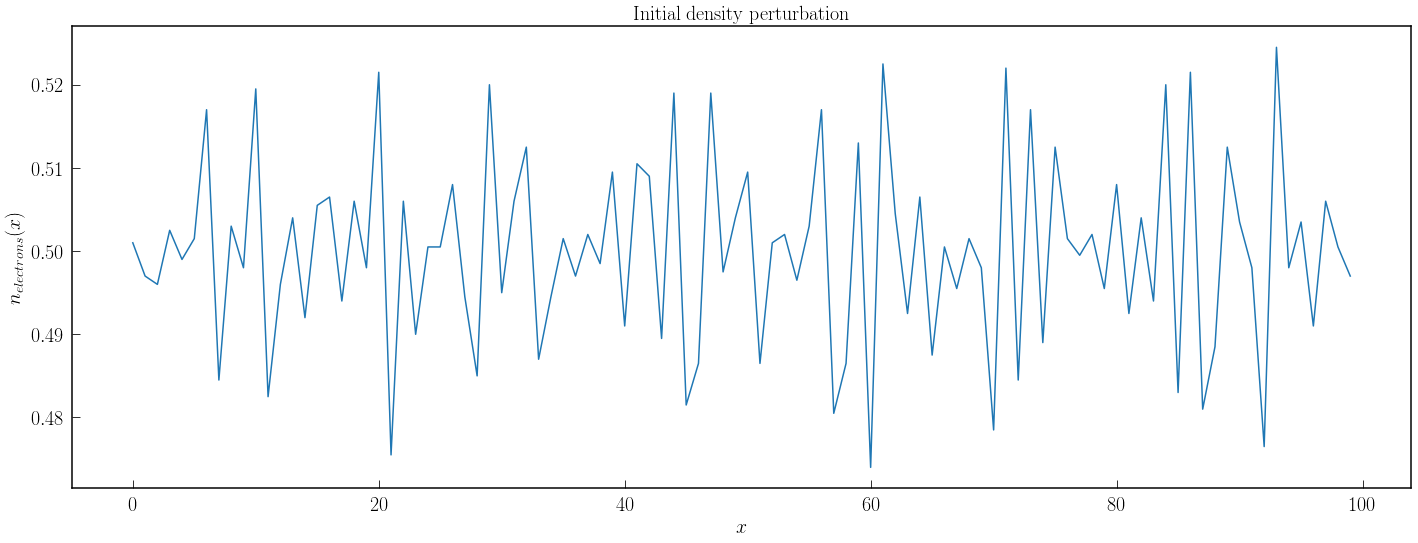

In [30]:
# # Plotting the initial density perturbation
pl.plot(number_density, label = r'$n$')
pl.title(r'$\mathrm{Initial\;density\;perturbation}$')
pl.xlabel('$x$')
pl.ylabel(r'$n_{electrons}(x)$')
pl.show()
pl.clf()

In [31]:
# Time parameters
start_time = 0

end_time   = 2

dt         = 0.002

time       = np.arange(    start_time,\
                           end_time + dt,\
                           dt,\
                           dtype = np.double\
                      )

In [32]:
# Some variables for storing data
Ex_max       = np.zeros(len(time), dtype = np.double)
Ey_max       = np.zeros(len(time), dtype = np.double)

In [33]:
# Charge deposition using linear weighting scheme

rho_electrons  = cloud_charge_deposition(charge_electron,\
                            number_of_electrons,\
                            positions_x,\
                            positions_y,\
                            x_grid,\
                            y_grid,\
                            charge_b1_depositor,\
                            ghost_cells,\
                            length_domain_x,\
                            length_domain_y,\
                            dx,\
                            dy\
                           )

rho_initial    = norm_background_ions(rho_electrons, number_of_electrons, w_p, charge_electron) 

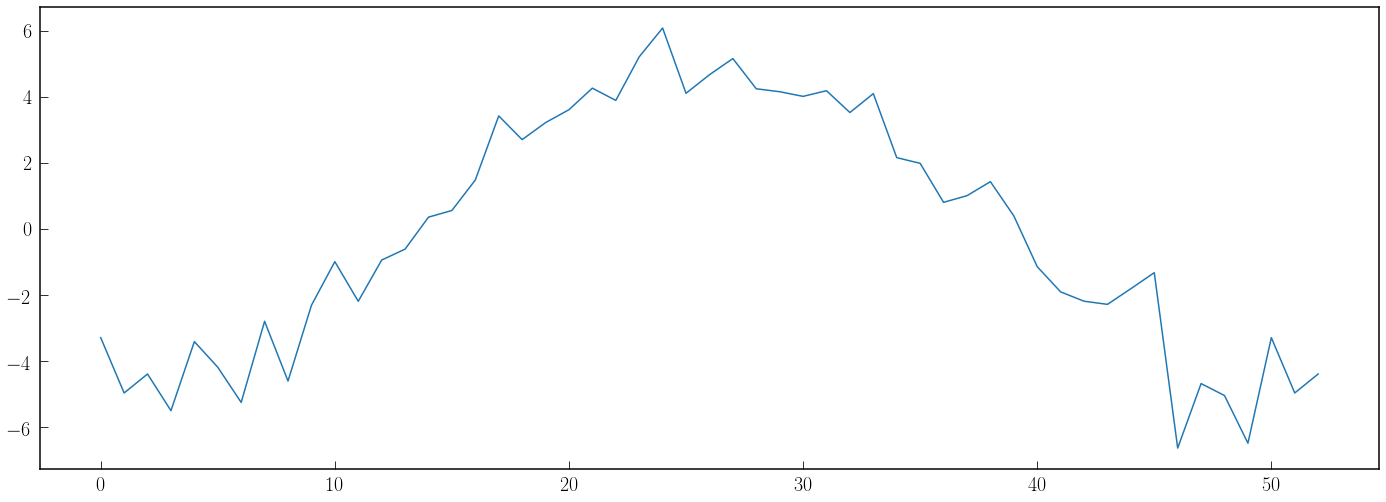

In [34]:
# # plotting intial rho in the system considering background ions
pl.plot(np.array(rho_initial)[1,:])
pl.show()
pl.clf()

In [35]:
# Computing the initial electric fields Ex and Ey
Ex_initial_centered = af.data.constant(0, y_grid.elements(), x_grid.elements(), dtype = af.Dtype.f64)
Ey_initial_centered = af.data.constant(0, y_grid.elements(), x_grid.elements(), dtype = af.Dtype.f64)

rho_physical = rho_initial[ghost_cells:-ghost_cells, ghost_cells:-ghost_cells].copy()

Ex_temp, Ey_temp = fft_poisson(rho_physical, dx, dy)

rho.dims() is  (51, 51)


In [36]:
Ex_initial_centered[ghost_cells:-ghost_cells\
                    ,ghost_cells:-ghost_cells\
                   ]                           = Ex_temp.copy()

Ey_initial_centered[ghost_cells:-ghost_cells\
                    ,ghost_cells:-ghost_cells\
                   ]                           = Ey_temp.copy()

Ex_initial_centered = periodic_ghost(Ex_initial_centered, ghost_cells)
Ey_initial_centered = periodic_ghost(Ey_initial_centered, ghost_cells)

In [37]:
Divergence_E =   (af.shift(Ex_initial_centered, 0, -1) - af.shift(Ex_initial_centered, 0, 1)) / (2 * dx) \
                +(af.shift(Ey_initial_centered, -1, 0) - af.shift(Ey_initial_centered, 1, 0)) / (2 * dy)

Divergence_E = periodic_ghost(Divergence_E, ghost_cells)    

Divergence_E_rho = Divergence_E - rho_initial

Divergence_E_rho_initial = Divergence_E_rho.copy()

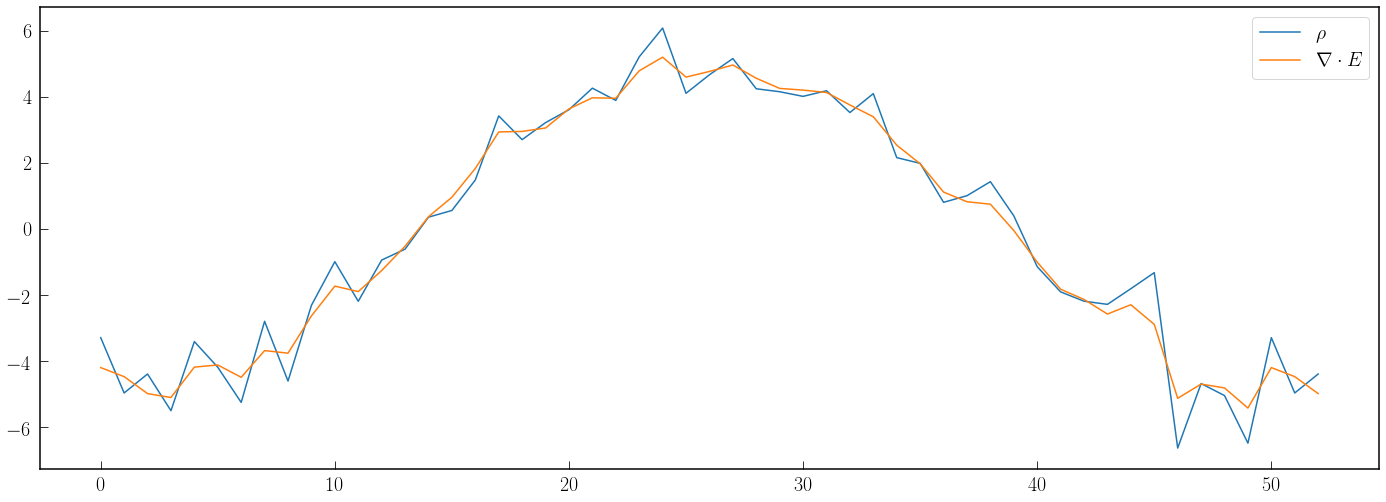

In [38]:
pl.plot(np.array(rho_initial)[1, :], label = r'$\rho$')
pl.plot(np.array(Divergence_E)[1, :], label = r'$\nabla \cdot E$')
pl.legend()
pl.show()
pl.clf()

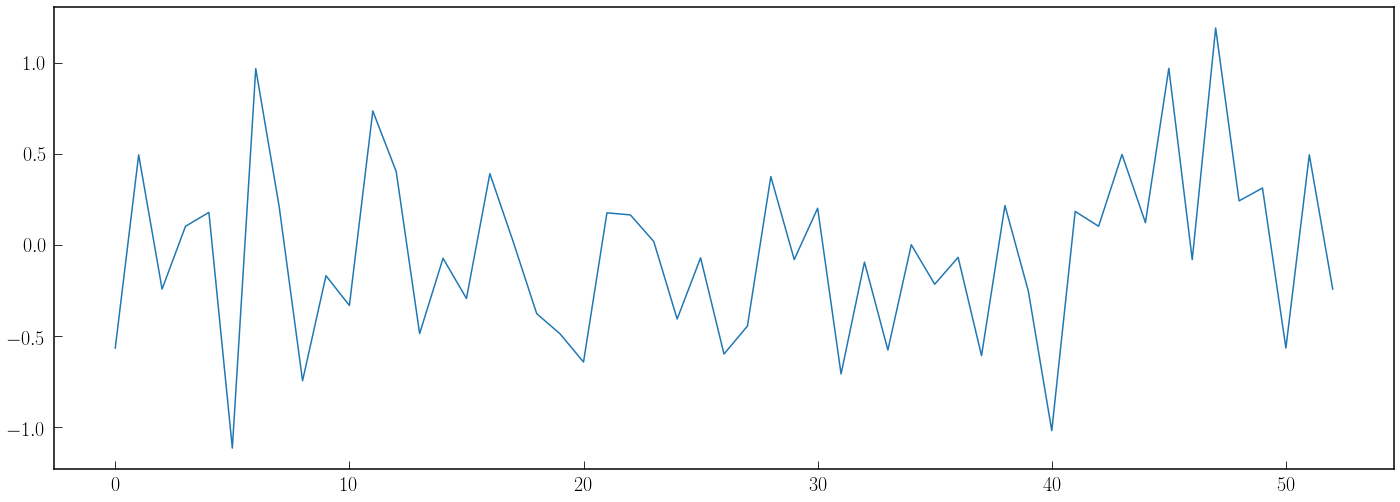

In [39]:
pl.plot(np.array(Divergence_E_rho)[:, 1])
pl.show()
pl.clf()

In [40]:
# Bringing Ex_initial_centered, Ey_initial_centered to Yee grid
Ex_initial_Yee = 0.5 * (Ex_initial_centered + af.shift(Ex_initial_centered, 0, -1))
Ex_initial_Yee = periodic_ghost(Ex_initial_Yee, ghost_cells)

Ey_initial_Yee = 0.5 * (Ey_initial_centered + af.shift(Ey_initial_centered, -1, 0))
Ey_initial_Yee = periodic_ghost(Ey_initial_Yee, ghost_cells)

The following cell block determines $v(\frac{\Delta t}{2})$:
\begin{align}
v(\frac{\Delta t}{2}) = v(t = 0) + E_{x}\left(x(\frac{\Delta t}{2})\right)\frac{\Delta t}{2}
\end{align}

In [41]:
# This cell block is to obtain v at (t = 0.5dt) to implement the verlet algorithm.

positions_x_half = positions_x + velocity_x * dt/2
positions_y_half = positions_y + velocity_y * dt/2

# Periodic Boundary conditions for particles 

positions_x_half, positions_y_half = periodic_particles(positions_x_half,\
                                                        positions_y_half,\
                                                        length_domain_x,\
                                                        length_domain_y\
                                                       )

# Finding interpolant fractions for the positions

fracs_Ex_x, fracs_Ex_y = fraction_finder(positions_x_half,\
                                         positions_y_half, \
                                         x_right, y_grid,\
                                         dx, dy\
                                        )

fracs_Ey_x, fracs_Ey_y = fraction_finder(positions_x_half,\
                                         positions_y_half, \
                                         x_grid, y_top,\
                                         dx, dy\
                                        )
# Interpolating the fields at each particle

Ex_particle = af.signal.approx2(Ex_initial_Yee, fracs_Ex_y, fracs_Ex_x)
Ey_particle = af.signal.approx2(Ey_initial_Yee, fracs_Ey_y, fracs_Ey_x)

# Updating the velocity using the interpolated Electric fields to find v at (t = 0.5dt)

velocity_x = velocity_x  + (Ex_particle * charge_electron / mass_electron ) * dt/2
velocity_y = velocity_y  + (Ey_particle * charge_electron / mass_electron ) * dt/2

Ex = Ex_initial_Yee.copy()
Ey = Ey_initial_Yee.copy()
Bz = 0 * Ey_initial_Yee.copy()
rho = rho_initial.copy()

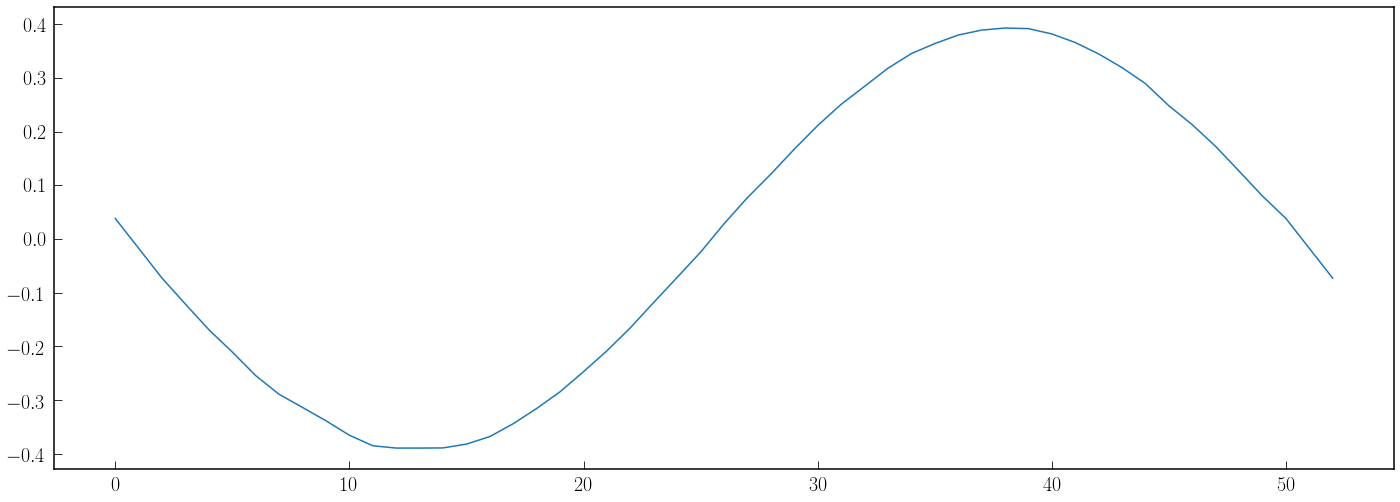

In [ ]:
pl.plot(np.array(Ex_initial_Yee)[:, 1])
pl.show()
pl.clf()

In [ ]:
for time_index in range(len(time)):
    if(time_index%25 ==0):
        print('Computing for time = ', time_index * dt)
        

    # Updating the positions of particle using the velocites (Verlet algorithm)
    # velocity at t = (n + 1/2) dt, positions_x at t = (n)dt and positions_x_new
    # at t = (n+1)dt
    positions_x_new = positions_x + velocity_x * dt
    positions_y_new = positions_y + velocity_y * dt


    # Computing the current densities on the Yee grid provided by Umeda's scheme

    Jx_Yee, Jy_Yee = Umeda_2003( charge_electron,\
                                 number_of_electrons,\
                                 positions_x, positions_y,\
                                 velocity_x, velocity_y,\
                                 x_grid, y_grid,\
                                 ghost_cells,\
                                 length_domain_x, length_domain_y,\
                                 dx, dy,\
                                 dt \
                                )

    # Normalizing and evaluation of current densities on the centered grid

    Jx_norm_Yee = current_norm_BC_Jx(Jx_Yee, number_of_electrons, w_p)
    Jy_norm_Yee = current_norm_BC_Jy(Jy_Yee, number_of_electrons, w_p)

    # Evolving electric fields using currents
    
    Ex_updated, Ey_updated, Bz_updated = fdtd(Ex, Ey, Bz, length_domain_x,\
                                              length_domain_y, ghost_cells,\
                                              Jx_norm_Yee, Jy_norm_Yee,\
                                              dt\
                                             )

    # Forcing Bz to be zero
    Bz_updated[:,:] = 0
    
    # calculating the interpolation fraction needed for arrayfire's 1D interpolation
    
    fracs_Ex_x, fracs_Ex_y = fraction_finder(positions_x_new, positions_y_new,\
                                             x_right, y_grid, dx, dy\
                                            )

    fracs_Ey_x, fracs_Ey_y = fraction_finder(positions_x_new, positions_y_new,\
                                             x_grid, y_top, dx, dy\
                                            )

    fracs_Bz_x, fracs_Bz_y = fraction_finder(positions_x_new, positions_y_new,\
                                             x_right, y_top, dx, dy\
                                            )


    # Interpolating the fields at particle locations
    
    Ex_particle = af.signal.approx2(Ex_updated, fracs_Ex_y, fracs_Ex_x)

    Ey_particle = af.signal.approx2(Ey_updated, fracs_Ey_y, fracs_Ey_x)
    
    # Computing the interpolated magnetic field at t = (n+1)*dt to push v((n+1/2) * dt)
    
    Bz_particle = af.signal.approx2((Bz_updated + Bz)/2, fracs_Bz_y, fracs_Bz_x)

    # Updating the velocity using the interpolated Electric fields

    velocity_x_new, velocity_y_new = Boris( charge_electron, mass_electron,\
                                            velocity_x, velocity_y, dt,\
                                            Ex_particle, Ey_particle, Bz_particle\
                                          )

    # Saving the Electric fields for plotting

    Ex_max[time_index]       = (af.max(af.abs(Ex[ghost_cells:-ghost_cells,ghost_cells:-ghost_cells])))
    Ey_max[time_index]       = (af.max(af.abs(Ey[ghost_cells:-ghost_cells,ghost_cells:-ghost_cells])))
    
    # Contour plots for rho and E
    
    rho_electrons  = cloud_charge_deposition(   charge_electron,\
                                                number_of_electrons,\
                                                positions_x_new,\
                                                positions_y_new,\
                                                x_grid,\
                                                y_grid,\
                                                charge_b1_depositor,\
                                                ghost_cells,\
                                                length_domain_x,\
                                                length_domain_y,\
                                                dx,\
                                                dy\
                                            )
    
    
    rho_updated              = norm_background_ions(rho_electrons, number_of_electrons, w_p, charge_electron) 
    
#     d_rho_dt      = (rho_updated - rho)/dt
    
#     d_Jx_dx       = (af.shift(Jx_norm_Yee, 0, 0) - af.shift(Jx_norm_Yee, 0, 1) )/ dx
#     d_Jx_dx[ghost_cells, :] = d_Jx_dx[-1 - ghost_cells, :].copy()
#     d_Jx_dx       =periodic_ghost(d_Jx_dx, ghost_cells)
    
#     d_Jy_dy       = (af.shift(Jy_norm_Yee, 0, 0) - af.shift(Jy_norm_Yee, 1, 0) )/ dy
#     d_Jy_dy[:, ghost_cells] = d_Jy_dy[:, -1 - ghost_cells].copy() 
#     d_Jy_dy       = periodic_ghost(d_Jy_dy, ghost_cells)
    
    
#     continuity    = np.array(d_Jx_dx + d_rho_dt + d_Jy_dy)
    
    Divergence_E =   (af.shift(Ex, 0, 0) - af.shift(Ex, 0, 1)) / (dx) \
                    +(af.shift(Ey, 0, 0) - af.shift(Ey, 1, 0)) / (dy)
        
    Divergence_E_rho = Divergence_E - rho
    
#     Divergence_E[ghost_cells, :] = Divergence_E[-1 - ghost_cells, :].copy()    
#     Divergence_E[:, ghost_cells] = Divergence_E[:, -1 - ghost_cells].copy()    
    
    Divergence_E = periodic_ghost(Divergence_E, ghost_cells)    

    
    
    Divergence_E_rho = periodic_ghost(Divergence_E_rho, ghost_cells) - Divergence_E_rho_initial
    
    
#     print('1', Divergence_E[ghost_cells + 1, ghost_cells:-ghost_cells])
#     print('2', rho[ghost_cells + 1, ghost_cells:-ghost_cells])
#     print('3', Divergence_E_rho[ghost_cells + 1, ghost_cells:-ghost_cells])
#     print('4', Divergence_E_rho[ghost_cells + 1, ghost_cells:-ghost_cells])

    
#     input('check')
    
#     pl.subplot(1, 2, 1)
    
#     pl.contourf(np.array(x_grid)[3:-3],\
#                 np.array(y_grid)[3:-3],\
#                 (continuity)[3:-3, 3:-3], 100, cmap = 'jet')
#     pl.xlabel('$x$')
#     pl.ylabel('$y$')
#     pl.title(r'$\frac{\partial \rho}{\partial t} + \nabla \cdot J(t)$')
#     pl.colorbar()
    
    pl.subplot(1, 2, 1)
    # Plotting rho movie
    pl.contourf(np.array(x_grid)[ghost_cells:-ghost_cells],\
                np.array(y_grid)[ghost_cells:-ghost_cells],\
                np.array(rho)[ghost_cells:-ghost_cells, ghost_cells:-ghost_cells], 100, cmap = 'jet')
    pl.xlabel('$x$')
    pl.ylabel('$y$')
    pl.title(r'$\rho(t))$')
    pl.colorbar()
    
    
    pl.subplot(1, 2, 2)
    
    # Plotting divergence movie
    
    pl.contourf(np.array(x_grid)[ghost_cells:-ghost_cells],\
            np.array(y_grid)[ghost_cells:-ghost_cells],\
            np.array(Divergence_E_rho)[ghost_cells:-ghost_cells, ghost_cells:-ghost_cells], 100, cmap = 'jet')
    
    
    pl.xlabel('$x$')
    pl.ylabel('$y$')
    pl.colorbar()
    pl.title(r'$\nabla \cdot E(t) - \rho(t)$')
    pl.savefig('temp2/'+ str(time_index)+'.png')
    pl.clf()
    
    
    # Periodic Boundary conditions for particles
    positions_x_new, positions_y_new = periodic_particles(positions_x_new, positions_y_new,\
                                                          length_domain_x, length_domain_y\
                                                         )
    
    # Saving the updated quantities for the next timestep
    
    velocity_x  = velocity_x_new.copy()
    positions_x = positions_x_new.copy()
    velocity_y  = velocity_y_new.copy()
    positions_y = positions_y_new.copy()
    Ex          = Ex_updated.copy()
    Ey          = Ey_updated.copy()
    rho         = rho_updated.copy()

Computing for time =  0.0
Computing for time =  0.05
Computing for time =  0.1
Computing for time =  0.15
Computing for time =  0.2
Computing for time =  0.25
Computing for time =  0.3
Computing for time =  0.35000000000000003
Computing for time =  0.4
Computing for time =  0.45
Computing for time =  0.5
Computing for time =  0.55
Computing for time =  0.6
Computing for time =  0.65
Computing for time =  0.7000000000000001
Computing for time =  0.75
Computing for time =  0.8
Computing for time =  0.85
Computing for time =  0.9
Computing for time =  0.9500000000000001
Computing for time =  1.0
Computing for time =  1.05
Computing for time =  1.1
Computing for time =  1.1500000000000001
Computing for time =  1.2
Computing for time =  1.25
Computing for time =  1.3
Computing for time =  1.35
Computing for time =  1.4000000000000001
Computing for time =  1.45
Computing for time =  1.5
Computing for time =  1.55
Computing for time =  1.6
Computing for time =  1.6500000000000001


### Comparing the plots from both Linear theory calculations and Electrostatic PIC below

In [ ]:
h5f = h5py.File('PIC_2D_CD.h5', 'w')
h5f.create_dataset('Ex_amp', data = (Ex_max))
h5f.create_dataset('Ey_amp', data = (Ey_max))
h5f.close()

In [ ]:
# Reading data generated by the Cheng Knorr code
h5f = h5py.File('CK_256.h5', 'r')
Ex_max_CK = h5f['max_E'][:]
h5f.close()
time_CK = np.linspace(0,time[-1], len(Ex_max_CK))

In [ ]:
time_grid = np.linspace(0, time[-1], len(Ex_max))
pl.plot(time_grid, Ex_max , label = r'$\mathrm{PIC}$')
# pl.plot(time_LT, Ex_max_LT,'--',lw = 3,label = '$\mathrm{LT}$')
pl.plot(time_CK, Ex_max_CK, label = '$\mathrm{Cheng\;Knorr}$')
# print('(abs(Ex_amplitude[0])) is ',(abs(Ex_amplitude[0])))
# print('(abs(Ex_max[0])) is ',(abs(Ex_max[0])))
pl.xlabel('$t$')
pl.ylabel('$\mathrm{MAX}(|E_{x}|)$')
pl.legend()
pl.show()
pl.savefig('MaxE.png')
pl.clf()

In [ ]:
pl.semilogy(time_grid, Ex_max ,label = r'$\mathrm{PIC}$')
# pl.semilogy(time_LT, Ex_max_LT,'--',lw = 3,label = '$\mathrm{LT}$')
pl.semilogy(time_CK,Ex_max_CK, label = '$\mathrm{Cheng\;Knorr}$')
pl.legend()
pl.xlabel('$t$')
pl.ylabel('$\mathrm{MAX}(|E_{x}|)$')
pl.show()
pl.savefig('MaxE_semilogy.png')
pl.clf()

In [ ]:
pl.loglog(time_grid, Ex_max ,label = r'$\mathrm{PIC}$')
# pl.loglog(time_LT, Ex_max_LT,'--',lw = 3,label = '$\mathrm{LT}$')
pl.semilogy(time_CK,Ex_max_CK, label = '$\mathrm{Cheng\;Knorr}$')
pl.legend()
pl.xlabel('$t$')
pl.ylabel('$\mathrm{MAX}(|E_{x}|)$')
pl.show()
pl.savefig('MaxE_loglog.png')
pl.clf()